Задание \
Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).

У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема, к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
exp = pd.read_csv('./experiment_lesson_4.csv')
exp.head()

order_id  delivery_time  district experiment_group
0      3159           44.0  Purlieus          control
1     10426           51.0  Purlieus          control
2      9155           46.0  Purlieus          control
3     10699           34.0  Purlieus          control
4     10061           43.0  Purlieus          control

In [19]:
exp.experiment_group.value_counts()

test       10104
control    10092
Name: experiment_group, dtype: int64

In [5]:
exp.shape

(20196, 4)

In [7]:
exp.dtypes

order_id              int64
delivery_time       float64
district             object
experiment_group     object
dtype: object

In [9]:
exp.isna().sum()

order_id            0
delivery_time       0
district            0
experiment_group    0
dtype: int64

Для начала давайте сформулируем гипотезы для проверки

- Нулевая гипотеза (H0): Разницы между средним временем доставки в тестовой и контрольной группе нет
- Альтернативная гипотеза (H1): Разница между средним временем доставки в тестовой и контрольной группе есть

Сопоставьте графики распределения и  экспериментальные группы:

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

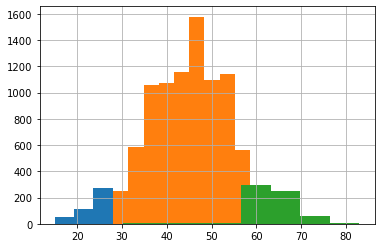

In [21]:
exp.query('experiment_group == "control"').groupby('district').delivery_time.hist()

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

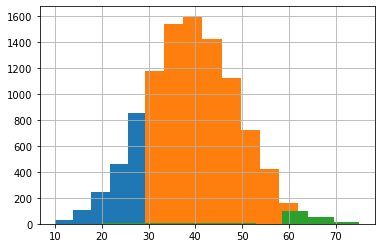

In [22]:
exp.query('experiment_group == "test"').groupby('district').delivery_time.hist()

Посчитайте количество наблюдений в тестовой и контрольной группе. На сколько по модулю отличается количество наблюдений в тесте и контроле?

In [24]:
exp.experiment_group.value_counts().loc['test']

10104

In [25]:
exp.experiment_group.value_counts().loc['control']

10092

In [26]:
np.abs(exp.experiment_group.value_counts().loc['test'] - exp.experiment_group.value_counts().loc['control'])

12

Теперь давайте изучим наши распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.

In [32]:
stats.shapiro(exp.query('experiment_group == "test"').delivery_time.sample(1000, random_state=17))

ShapiroResult(statistic=0.9975475668907166, pvalue=0.14005419611930847)

In [33]:
stats.shapiro(exp.query('experiment_group == "control"').delivery_time.sample(1000, random_state=17))

ShapiroResult(statistic=0.9974725842475891, pvalue=0.12411931157112122)

In [38]:
np.round(exp.query('experiment_group == "test"').delivery_time.std(), 2)

9.88

In [39]:
np.round(exp.query('experiment_group == "control"').delivery_time.std(), 2)

9.99

Для того, чтобы проверить нормальность распределения я использую Shapiro-Wilk test. Этот тест показывает, что значения в тестовой группе распределены нормально. В контрольной группе распределение является нормальным. \
Стандартное отклонение времени доставки в тесте равно (округлите до сотых) 9.88. Стандартное отклонение времени доставки в контроле равно (округлите до сотых) 
9.99


Пришло время сравнить средние в тесте и контроле

In [40]:
stats.ttest_ind(exp.query('experiment_group == "test"').delivery_time, exp.query('experiment_group == "control"').delivery_time)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

Для сравнения средних в данных экспериментальных группах я использую 
Student's t-test
- Статистика в тесте равна (округлите до целого) -43
- p-value <= 0.05


На сколько процентов изменилось среднее время доставки в тестовой группе (округлите до сотых)? 

In [44]:
test_mean = exp.query('experiment_group == "test"').delivery_time.mean()
test_mean

39.04681314330958

In [46]:
control_mean = exp.query('experiment_group == "control"').delivery_time.mean()
control_mean

45.065101070154576

In [48]:
round((test_mean - control_mean) / control_mean * 100, 2)

-13.35

Что в итоге? Катим? 

Да, раскатываем новый алгоритм на всех, так как среднее время доставки статистически значимо изменилось. Среднее время доставки в тесте меньше, чем в контроле.